In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Libraries Used**

In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as sms
import statsmodels.api as sm

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MAS648/Project/fraud.csv')

In [ ]:
df.head()

,dates,products,state,US,amount,card,fico,balance,income,Fraud
0,2022-12-06,Dining,AL,True,103.36,Amex,834,-298.10,104000.0,0
1,2022-10-10,Shopping,CA,True,46.83,Visa,671,10742.99,138000.0,0
2,2022-06-02,Entertainment,AL,True,332.25,Visa,541,6548.43,86000.0,0
3,2022-09-25,Dining,AZ,True,452.21,Amex,770,14311.15,340000.0,0
4,2022-05-26,Entertainment,AL,True,313.77,Amex,451,2165.65,55000.0,0


In [ ]:
df.describe()

,amount,fico,balance,income,Fraud
count,17058.000000,17058.000000,17058.000000,17058.000000,17058.000000
mean,228.102047,637.385684,3697.432125,88371.848986,0.082073
std,857.299665,96.642244,3983.905005,81556.964815,0.274484
min,16.750000,276.000000,-2545.880000,2000.000000,0.000000
25%,84.962500,572.000000,1352.497500,35000.000000,0.000000
50%,131.770000,640.000000,2121.455000,78000.000000,0.000000
75%,204.700000,703.000000,5093.130000,119000.000000,0.000000
max,25949.650000,850.000000,34049.940000,779000.000000,1.000000


In [ ]:
#Viewing options for dummies
print(df['US'].value_counts())
print(df['products'].value_counts())
print(df['card'].value_counts())

True     14429
False     2629
Name: US, dtype: int64
Shopping         5480
Groceries        4087
Entertainment    4062
Dining           2642
Travel            787
Name: products, dtype: int64
Visa          6354
Mastercard    4251
Amex          4078
Discover      2375
Name: card, dtype: int64


In [ ]:
#Change Datatype for dates
df['dates'].dtype

dtype('O')

In [ ]:
df['dates'] = pd.to_datetime(df['dates'])

In [ ]:
# Check the data type of the 'date_column'
df['dates'].dtype

dtype('<M8[ns]')

In [ ]:
print(df.dtypes)

dates       datetime64[ns]
products            object
state               object
US                    bool
amount             float64
card                object
fico                 int64
balance            float64
income             float64
Fraud                int64
dtype: object


Creating a Time Feature (Age)

In [ ]:
latest_date = df['dates'].max()

# Calculated the age of the account in months by subtracting each date from the latest date
df['age'] = (latest_date - df['dates']).dt.days/30.4375

df['age'].describe()

count    17058.000000
mean         5.662987
std          3.566320
min          0.000000
25%          2.398357
50%          5.552361
75%          8.772074
max         11.958932
Name: age, dtype: float64

Cleaning Data and dropping States, to only include top 5 states.

In [ ]:
df_new = pd.get_dummies(df, columns=['US', 'state', 'products', 'card'])

In [ ]:
#Drop columns by index positions from 14 to 58 (dropping states not in top 5 distribution)
df_new = df_new.drop(df_new.columns[14:59], axis=1)

In [ ]:
df_new.head()


,dates,amount,fico,balance,income,Fraud,age,US_False,US_True,state_AK,...,state_CA,products_Dining,products_Entertainment,products_Groceries,products_Shopping,products_Travel,card_Amex,card_Discover,card_Mastercard,card_Visa
0,2022-12-06,103.36,834,-298.10,104000.0,0,0.821355,0,1,0,...,0,1,0,0,0,0,1,0,0,0
1,2022-10-10,46.83,671,10742.99,138000.0,0,2.694045,0,1,0,...,1,0,0,0,1,0,0,0,0,1
2,2022-06-02,332.25,541,6548.43,86000.0,0,6.965092,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,2022-09-25,452.21,770,14311.15,340000.0,0,3.186858,0,1,0,...,0,1,0,0,0,0,1,0,0,0
4,2022-05-26,313.77,451,2165.65,55000.0,0,7.195072,0,1,0,...,0,0,1,0,0,0,1,0,0,0


In [ ]:
df_new.columns

Index(['dates', 'amount', 'fico', 'balance', 'income', 'Fraud', 'age',
       'US_False', 'US_True', 'state_AK', 'state_AL', 'state_AR', 'state_AZ',
       'state_CA', 'products_Dining', 'products_Entertainment',
       'products_Groceries', 'products_Shopping', 'products_Travel',
       'card_Amex', 'card_Discover', 'card_Mastercard', 'card_Visa'],
      dtype='object')

**Descriptive Analysis**

- Barplots

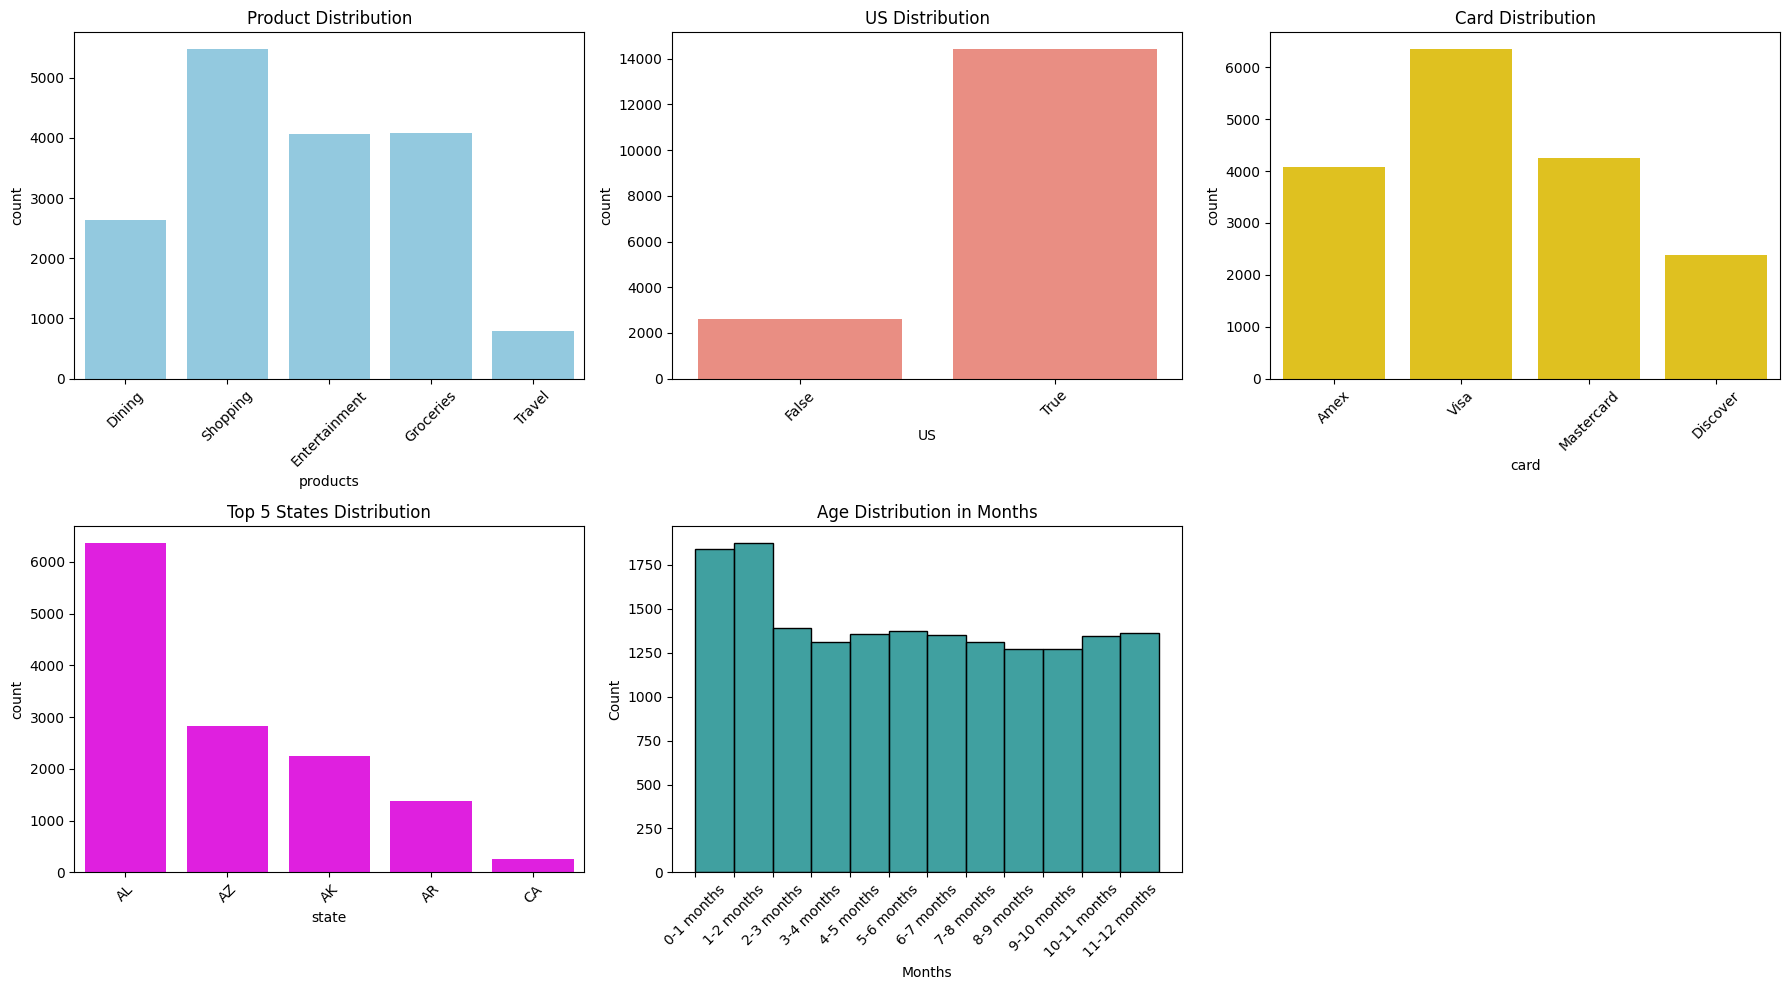

In [ ]:
# Custom Colors
custom_colors = ["skyblue", "salmon", "gold", "magenta", "teal"]

# Create subplots for each categorical column
plt.figure(figsize=(18, 10))

# Barplot for 'products'
plt.subplot(231)
sns.countplot(data=df, x='products', color=custom_colors[0])
plt.title('Product Distribution')
plt.xticks(rotation=45)

# Barplot for 'US'
plt.subplot(232)
sns.countplot(data=df, x='US', color=custom_colors[1])
plt.title('US Distribution')
plt.xticks(rotation=45)

# Barplot for 'card'
plt.subplot(233)
sns.countplot(data=df, x='card', color=custom_colors[2])
plt.title('Card Distribution')
plt.xticks(rotation=45)

# Calculate the top 5 states
top_states = df['state'].value_counts().nlargest(5).index.tolist()

# Filter the DataFrame for the top 5 states
df_top_states = df[df['state'].isin(top_states)]

# Barplot for the top 5 states
plt.subplot(234)
sns.countplot(data=df_top_states, x='state', color=custom_colors[3], order=top_states)
plt.title('Top 5 States Distribution')
plt.xticks(rotation=45)


# Define bin edges corresponding to month ranges
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # Define your specific bins
labels = ['0-1 months', '1-2 months', '2-3 months', '3-4 months', '4-5 months',
          '5-6 months', '6-7 months', '7-8 months', '8-9 months', '9-10 months',
          '10-11 months', '11-12 months']  # Labels for the bins

# BarPlot of age of account distribution in months
plt.subplot(235)
sns.histplot(data=df, x='age', bins=bins, kde=False, color=custom_colors[4])
plt.title('Age Distribution in Months')
plt.xlabel('Months')
plt.ylabel('Count')
plt.xticks(bins[:-1], labels, rotation=45)  # Exclude the last bin edge for correct alignment


plt.tight_layout()  # Adjusts subplot parameters for better layout
plt.show()



-CORR Plot





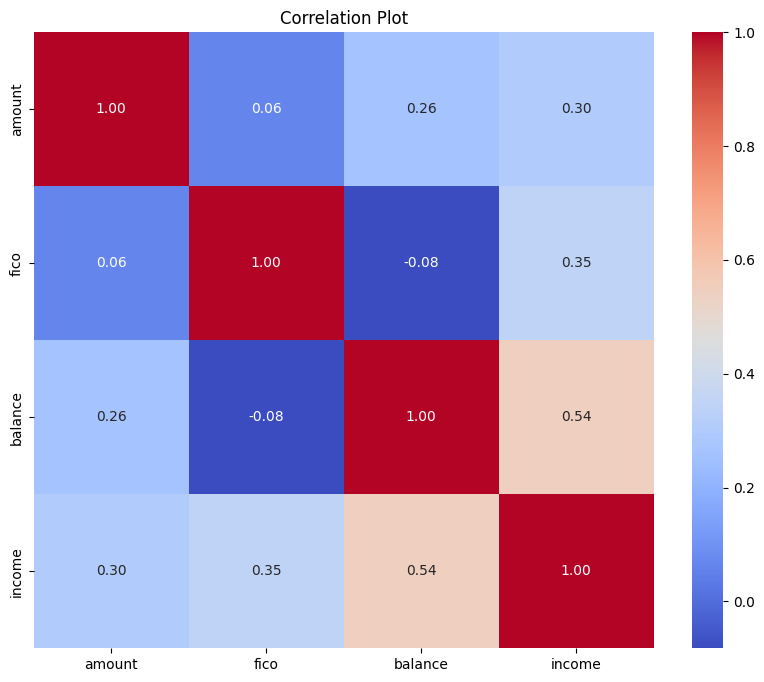

In [ ]:
# Selecting specific columns for correlation
selected_columns = ['amount', 'fico', 'balance', 'income']

# Create correlation_data with selected columns
correlation_data = df[selected_columns]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Plot')
plt.show()


- Scatterplots

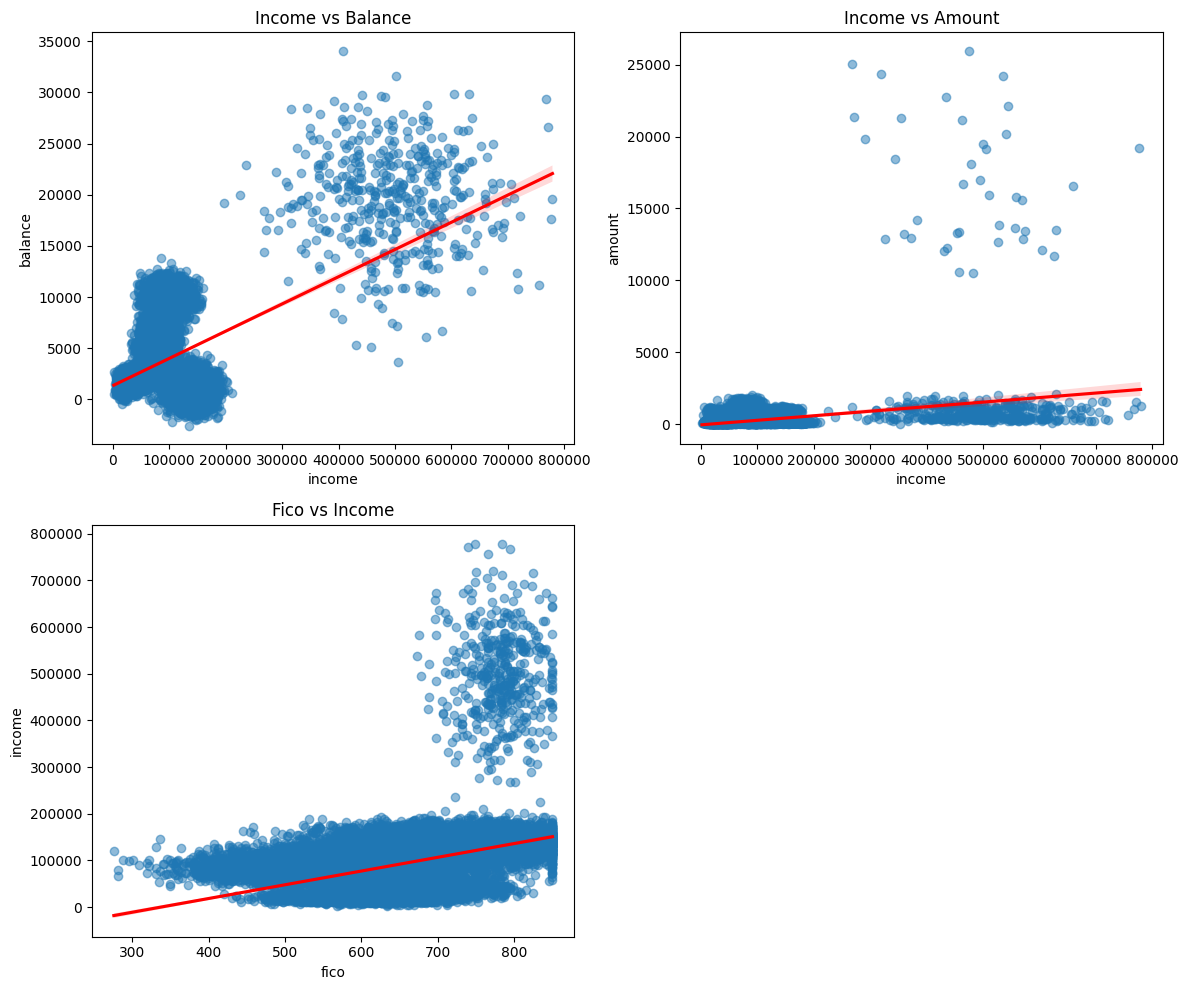

In [ ]:
plt.figure(figsize=(12, 10))

# Income vs Balance
plt.subplot(221)
plt.scatter(df['income'], df['balance'], alpha=0.5)
plt.title('Income vs Balance')
plt.xlabel('Income')
plt.ylabel('Balance')
sns.regplot(x=df['income'], y=df['balance'], scatter=False, color='red')  # Adding a regression line

# Income vs Amount
plt.subplot(222)
plt.scatter(df['income'], df['amount'], alpha=0.5)
plt.title('Income vs Amount')
plt.xlabel('Income')
plt.ylabel('Amount')
sns.regplot(x=df['income'], y=df['amount'], scatter=False, color='red')  # Adding a regression line

# Fico vs Income
plt.subplot(223)
plt.scatter(df['fico'], df['income'], alpha=0.5)
plt.title('Fico vs Income')
plt.xlabel('Fico')
plt.ylabel('Income')
sns.regplot(x=df['fico'], y=df['income'], scatter=False, color='red')  # Adding a regression line

plt.tight_layout()
plt.show()



**Model 1: Interpretable Model Logistic**

- Defining X and Y

For X we dropped "dates" and our response variable "Fraud"

In [ ]:
y = df_new['Fraud']
X = df_new.drop(columns=[df_new.columns[0], df_new.columns[5],'amount', 'income', 'US_True', 'products_Dining', 'products_Groceries', 'products_Travel', 'card_Amex',
                         'card_Discover', 'card_Mastercard', 'card_Visa'])

In [ ]:
X.columns

Index(['fico', 'balance', 'age', 'US_False', 'state_AK', 'state_AL',
       'state_AR', 'state_AZ', 'state_CA', 'products_Entertainment',
       'products_Shopping'],
      dtype='object')

In [ ]:
continuous_features = ['fico', 'balance',
                       'age', 'US_False', 'state_AK',
                       'state_AL', 'state_AR', 'state_AZ', 'state_CA',
                       'products_Entertainment', 'products_Shopping']
scaler_continuous = StandardScaler()
X[continuous_features] = scaler_continuous.fit_transform(X[continuous_features])

- Normal Logistic

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Add a constant to the X_train dataset
X_train = sm.add_constant(X_train)

# Fit a logistic regression model with statsmodels
model = sm.Logit(y_train, X_train).fit()

# Display the model summary
print(model.summary())

# Add a constant to the X_test dataset
X_test = sm.add_constant(X_test)

# Make predictions on the test set
predictions = (model.predict(X_test) > 0.5).astype(int)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, predictions)
print(f"\nAccuracy: {accuracy:.2%}")

# Display additional classification metrics
print("\nClassification Report:")
print(classification_report(y_test, predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, model.predict(X_test))
print(f"\nAUC: {auc_roc:.2f}")


Optimization terminated successfully.
         Current function value: 0.237634
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  Fraud   No. Observations:                13646
Model:                          Logit   Df Residuals:                    13634
Method:                           MLE   Df Model:                           11
Date:                Thu, 07 Dec 2023   Pseudo R-squ.:                  0.1653
Time:                        02:12:31   Log-Likelihood:                -3242.7
converged:                       True   LL-Null:                       -3884.9
Covariance Type:            nonrobust   LLR p-value:                1.066e-268
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -3.0843      0.060    -51.257      0.000      -3.202     

- Lasso Model




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Add a constant to the X_train dataset
X_train = sm.add_constant(X_train)

# Fit a logistic regression model with statsmodels
model = sm.Logit(y_train, X_train).fit()

# Display the model summary
print(model.summary())

# Add a constant to the X_test dataset
X_test = sm.add_constant(X_test)

# Make predictions on the test set
predictions = (model.predict(X_test) > 0.5).astype(int)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, predictions)
print(f"\nAccuracy: {accuracy:.2%}")

# Display additional classification metrics
print("\nClassification Report:")
print(classification_report(y_test, predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, model.predict(X_test))
print(f"\nAUC-ROC: {auc_roc:.2f}")

# Lasso logistic regression model
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Train the model
lasso_model.fit(X_train, y_train)

# Display the model summary
lasso_model_coef = dict(zip(X.columns, lasso_model.coef_[0]))
print("\nLasso Logistic Regression Model Coefficients:")
for feature, coef in lasso_model_coef.items():
    print(f"{feature}: {coef}")

# Predict on the test set
predictions = lasso_model.predict(X_test)

# Evaluate the model
accuracy = lasso_model.score(X_test, y_test)
print(f"\nAccuracy (Lasso Logistic Regression): {accuracy:.2%}")

# Predict probabilities
probabilities = lasso_model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, probabilities)
print(f'The AUC is: {auc:.2f}')


Optimization terminated successfully.
         Current function value: 0.237634
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  Fraud   No. Observations:                13646
Model:                          Logit   Df Residuals:                    13634
Method:                           MLE   Df Model:                           11
Date:                Thu, 07 Dec 2023   Pseudo R-squ.:                  0.1653
Time:                        02:12:32   Log-Likelihood:                -3242.7
converged:                       True   LL-Null:                       -3884.9
Covariance Type:            nonrobust   LLR p-value:                1.066e-268
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -3.0843      0.060    -51.257      0.000      -3.202     

In [ ]:
cross_val_scores = cross_val_score(lasso_model, X_train, y_train, cv = 5, scoring='accuracy')
cross_val_scores

array([0.91684982, 0.91828509, 0.91718578, 0.92121656, 0.91975082])

In [ ]:
# Corss validation mean for accuracy
avg_cross_val_error = np.mean(cross_val_scores)
avg_cross_val_error

0.9186576145242323

- Ridge Model

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Add a constant to the X_train dataset
X_train = sm.add_constant(X_train)

# Fit a logistic regression model with statsmodels
model = sm.Logit(y_train, X_train).fit()

# Display the model summary
print(model.summary())

# Add a constant to the X_test dataset
X_test = sm.add_constant(X_test)

# Make predictions on the test set
predictions = (model.predict(X_test) > 0.5).astype(int)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, predictions)
print(f"\nAccuracy: {accuracy:.2%}")

# Display additional classification metrics
print("\nClassification Report:")
print(classification_report(y_test, predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, model.predict(X_test))
print(f"\nAUC-ROC: {auc_roc:.2f}")

# Ridge logistic regression model
ridge_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Train the model
ridge_model.fit(X_train, y_train)

# Display the model summary
ridge_model_coef = dict(zip(X.columns, ridge_model.coef_[0]))
print("\nRidge Logistic Regression Model Coefficients:")
for feature, coef in ridge_model_coef.items():
    print(f"{feature}: {coef}")

# Predict on the test set
predictions = ridge_model.predict(X_test)

# Evaluate the model
accuracy = ridge_model.score(X_test, y_test)
print(f"\nAccuracy (Ridge Logistic Regression): {accuracy:.2%}")

# Predict probabilities
probabilities = ridge_model.predict_proba(X_test)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_test, probabilities)
print(f'The AUC is: {auc:.2f}')

# ROC and AUC
fpr_ridge, tpr_ridge, thresholds = roc_curve(y_test, probabilities)
auc_ridge= roc_auc_score(y_test, probabilities)
print(f"\nRidge AUC: {auc}")


Optimization terminated successfully.
         Current function value: 0.237634
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  Fraud   No. Observations:                13646
Model:                          Logit   Df Residuals:                    13634
Method:                           MLE   Df Model:                           11
Date:                Thu, 07 Dec 2023   Pseudo R-squ.:                  0.1653
Time:                        02:12:34   Log-Likelihood:                -3242.7
converged:                       True   LL-Null:                       -3884.9
Covariance Type:            nonrobust   LLR p-value:                1.066e-268
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -3.0843      0.060    -51.257      0.000      -3.202     

In [ ]:
cross_val_scores1 = cross_val_score(ridge_model, X_train, y_train, cv = 5, scoring='accuracy')
cross_val_scores1

array([0.91684982, 0.91828509, 0.91718578, 0.92121656, 0.91975082])

In [ ]:
# Corss validation mean for accuracy
avg_cross_val_error1 = np.mean(cross_val_scores)
avg_cross_val_error1

0.9186576145242323

**Model 2: KNN Model, k=12**

Split data 80-20 split

In [ ]:
Y = df_new['Fraud']
X = df_new.drop(columns=[df_new.columns[0], df_new.columns[5]])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=42)


In [ ]:
#To verify size of train
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(13646, 21)
(3412, 21)
(13646,)
(3412,)


- Scale Features

In [ ]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train) # Fits and transforms x_train
X_test_sc = sc.transform(X_test) #Transforms x_test


Print Size

In [ ]:
print(X_train_sc.shape)
print(X_test_sc.shape)

(13646, 21)
(3412, 21)


Veryifying that mean is 0  and Stand Deviation is 1

In [ ]:
print(np.mean(X_train_sc, axis = 0)) #mean should be 0
print(np.std(X_train_sc, axis=0)) #std should be 1
print(np.mean(X_test_sc, axis = 0)) #mean should be 0
print(np.std(X_test_sc, axis=0))

[ 4.16557371e-18  2.13485653e-16  1.11429097e-16  3.22831963e-17
 -1.25487908e-16 -5.62352451e-17  5.62352451e-17  6.28741282e-17
 -2.91590160e-17  3.74901634e-17 -2.03071718e-17  1.14553277e-17
 -3.61884216e-17 -3.12418028e-18 -7.81045071e-17 -1.16636064e-16
 -4.94661878e-17 -8.38321709e-17  4.16557371e-17 -5.20696714e-18
  2.13485653e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-0.02288384 -0.01298217 -0.04478398 -0.0450654  -0.00217846 -0.01301797
  0.01301797  0.02368548 -0.00556462  0.02131711 -0.03664799  0.01865453
  0.0311086   0.00301568  0.01849944 -0.04700795  0.00802914  0.0071395
 -0.01377707 -0.0053324   0.00837798]
[0.79287094 0.94748045 0.92924136 0.91589412 1.00531302 0.98743075
 0.98743075 1.02544289 0.99853475 1.03230535 0.96635248 1.07163381
 1.0291371  1.00185032 1.01114701 0.98123109 1.01726325 1.0043469
 0.98552199 0.99689689 1.00218707]


- Find the best K value




In [ ]:
accuracy_scores = []

# Test different values of n_neighbors
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    accuracy = knn.score(X_test, Y_test)
    accuracy_scores.append(accuracy)

# Find the best value of n_neighbors based on the highest accuracy
best_k = np.argmax(accuracy_scores) + 1
print(f"Best value of k = {best_k}, with accuracy: {accuracy}")

Best value of k = 12, with accuracy: 0.9194021101992966


- Fit the KNN Classifier with k = 12 which is the best k and print metrics

In [ ]:
# Fit KNN with the best k value
best_k = 12
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_sc, Y_train)
Y_pred = knn.predict(X_test_sc)

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("KNN Confusion Matrix:")
print(cm)

# Classification report
print("\nKNN Classification Report:")
print(classification_report(Y_test, Y_pred))

# Calculate accuracy
accuracy = knn.score(X_test_sc, Y_test)
print(f"\nKNN Accuracy: {accuracy:.2%}")

# ROC and AUC
y_probs = knn.predict_proba(X_test_sc)[:, 1]  # Predicted probabilities for class 1
fpr_knn, tpr_knn, thresholds = roc_curve(Y_test, y_probs)
auc_knn= roc_auc_score(Y_test, y_probs)
print(f"\nKNN AUC: {auc}")

# Cross-validation
cv_scores = cross_val_score(knn, X_train_sc, Y_train, cv=5)  # Use knn as the estimator
print(f"\nKNN Cross-validation scores: {cv_scores}")
print(f"KNN Mean Cross Validation accuracy: {np.mean(cv_scores)}")



KNN Confusion Matrix:
[[3118   19]
 [ 245   30]]

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3137
           1       0.61      0.11      0.19       275

    accuracy                           0.92      3412
   macro avg       0.77      0.55      0.57      3412
weighted avg       0.90      0.92      0.90      3412


KNN Accuracy: 92.26%

KNN AUC: 0.7733781551569247

KNN Cross-validation scores: [0.92051282 0.91828509 0.92011726 0.92011726 0.91975082]
KNN Mean Cross Validation accuracy: 0.9197566498482586


**Model 3: Decision Tree Classifier**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=42)

In [ ]:
clf = DecisionTreeClassifier(random_state=42)

In [ ]:
# Train the classifier
clf.fit(X_train, Y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
conf_matrix = confusion_matrix(Y_test, y_pred)
class_report = classification_report(Y_test, y_pred)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred)

#ROC
fpr_clf, tpr_clf, thresholds = roc_curve(Y_test, y_pred)
auc_clf= roc_auc_score(Y_test, y_pred)

In [ ]:
# Print results
print(f'Decision Tree Accuracy: {accuracy}')
print(f'Decision Tree Confusion Matrix:\n{conf_matrix}')
print(f'Decision Tree Classification Report:\n{class_report}')

Decision Tree Accuracy: 0.9525205158264948
Decision Tree Confusion Matrix:
[[3055   82]
 [  80  195]]
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3137
           1       0.70      0.71      0.71       275

    accuracy                           0.95      3412
   macro avg       0.84      0.84      0.84      3412
weighted avg       0.95      0.95      0.95      3412



**Model 4: XGB**

In [ ]:
y = df_new['Fraud']
X = df_new.drop(columns=[df_new.columns[0], df_new.columns[5]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the XGB model with categorical support
xgb_model = XGBClassifier(random_state=42, enable_categorical=True)
xgb_model.fit(X_train, y_train)

# Predicting on test set
y_pred = xgb_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Predicting probabilities on the test set
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probability of class 1 (Fraud)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

#ROC
fpr_xgb, tpr_xgb, thresholds = roc_curve(Y_test, y_pred_prob)
auc_xgb= roc_auc_score(Y_test, y_pred_prob)


# Print the results
print(f"XGB Accuracy: {accuracy}")
print(f"XGB AUC Score: {auc_score}")
print("XGB Classification Report:")
print(report)

XGB Accuracy: 0.9610199296600235
XGB AUC Score: 0.9763862404729475
XGB Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3137
           1       0.82      0.67      0.73       275

    accuracy                           0.96      3412
   macro avg       0.89      0.83      0.86      3412
weighted avg       0.96      0.96      0.96      3412



**Module 5: Random Forect Classifier**

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building and fitting the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
rf_y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_report = classification_report(y_test, rf_y_pred)

# Predicting probabilities on the test set
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Probability of class 1 (Fraud)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

#ROC
fpr_rf, tpr_rf, thresholds = roc_curve(Y_test, y_pred_prob)
auc_rf= roc_auc_score(Y_test, y_pred_prob)

# Print the results
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest AUC Score: {auc_score}")
print("Random Forest Classification Report:")
print(rf_report)

Random Forest Accuracy: 0.9613130128956624
Random Forest AUC Score: 0.9668015185324716
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3137
           1       0.90      0.59      0.71       275

    accuracy                           0.96      3412
   macro avg       0.93      0.79      0.84      3412
weighted avg       0.96      0.96      0.96      3412



Feature Importance

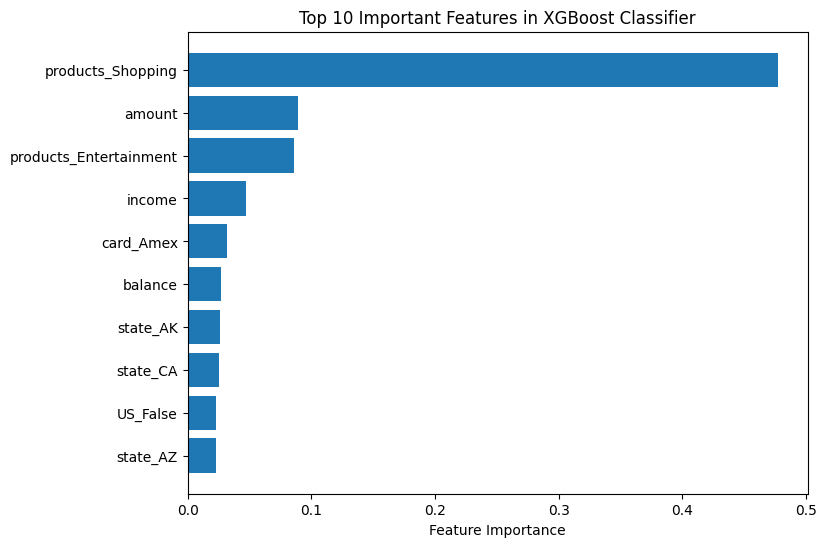

In [ ]:
feature_importance = xgb_model.feature_importances_
sorted_idx = feature_importance.argsort()

top_n = 10 # Select the top N features
top_idx = sorted_idx[-top_n:]  # Select indices of top N features

plt.figure(figsize=(8, 6))
plt.barh(range(len(top_idx)), feature_importance[top_idx], align='center')
plt.yticks(range(len(top_idx)), X.columns[top_idx])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features in XGBoost Classifier')
plt.show()

ROC Curve Plot Comparison

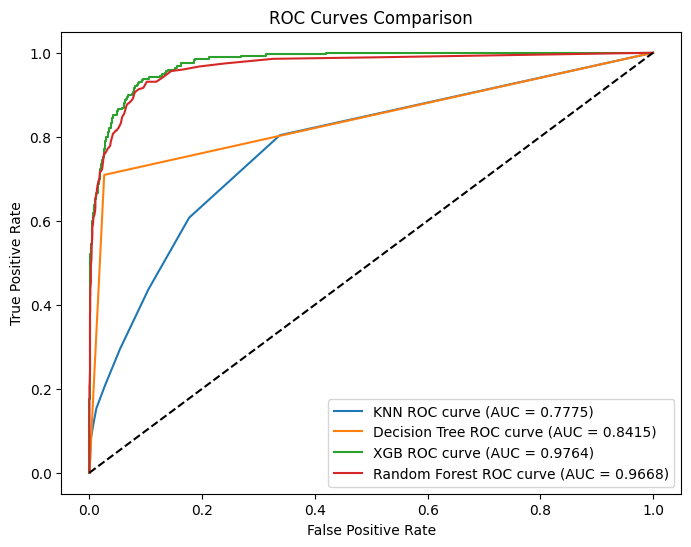

In [ ]:
plt.figure(figsize=(8, 6))

# Plot KNN ROC curve
plt.plot(fpr_knn, tpr_knn, label=f'KNN ROC curve (AUC = {auc_knn:.4f})')

# Plot Decision Tree ROC curve
plt.plot(fpr_clf, tpr_clf, label=f'Decision Tree ROC curve (AUC = {auc_clf:.4f})')

# Plot XGB ROC curve
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB ROC curve (AUC = {auc_xgb:.4f})')

# Plot Random Forest ROC curve
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest ROC curve (AUC = {auc_rf:.4f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--')

# Labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.show()



All Models Summary

In [ ]:
data = {
    'Model': ['Logistic', 'KNN (K=12)', 'Decision Tree', 'XGBoost', 'Random Forest'],
    'Accuracy': ['92.12%', '92.26%', '95.25%', '96.10%', '96.13%'],
    'Precision (Class 0/1)': ['92%/69%', '93%/61%', '97%/70%', '97%/82%', '97%/90%'],
    'Recall (Class 0/1)': ['100%/4%', '99%/11%', '97%/71%', '99%/67%', '99%/59%'],
    'F1-Score (Class 0/1)': ['96%/8%', '96%/19%', '97%/71%', '98%/73%', '98%/71%'],
    'AUC': [0.77, 0.7775, 0.8415, 0.9764, 0.9668]
}

df = pd.DataFrame(data)
df

,Model,Accuracy,Precision (Class 0/1),Recall (Class 0/1),F1-Score (Class 0/1),AUC
0,Logistic,92.12%,92%/69%,100%/4%,96%/8%,0.7700
1,KNN (K=12),92.26%,93%/61%,99%/11%,96%/19%,0.7775
2,Decision Tree,95.25%,97%/70%,97%/71%,97%/71%,0.8415
3,XGBoost,96.10%,97%/82%,99%/67%,98%/73%,0.9764
4,Random Forest,96.13%,97%/90%,99%/59%,98%/71%,0.9668
